    "AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster..."  

Data Dictionary

Sl_No: Primary key of the records

Customer Key: Customer identification number

Average Credit Limit: Average credit limit of each customer for all credit cards

Total credit cards: Total number of credit cards possessed by the customer

Total visits bank: Total number of visits that customer made (yearly) personally to the bank

Total visits online: Total number of visits or online logins made by the customer (yearly)

Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

##### Purpose: 

    * To understand and define the customers => spendings, tool of contact they prefer
    
    * Accomodate the existing customers with a better service than they already have
    
    * Up-front preparation for the new customers => being able to assign them to the appropriate cluster and meet their expectations
    
##### Problem Statement:
    * Using clustering algorithms, how to better market and service the customers

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

In [2]:
# Initializing excelfile library
xls = pd.ExcelFile('Credit_Card_Customer_Data.xlsx', engine='openpyxl',)

In [3]:
df = pd.read_excel(xls)

In [4]:
# make a copy of original data
data = df.copy()

In [5]:
print("Dataset contains {} rows and {} columns.".format(data.shape[0], data.shape[1]))

Dataset contains 660 rows and 7 columns.


In [6]:
# Get column names
data.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [7]:
# First 5 rows
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [8]:
# Last 5 rows
data.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [9]:
# Get datatype on each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


All columns are integer datatype

In [10]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No Null values!

In [11]:
data.duplicated().sum()

0

No duplicate values!

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


Observations:
* Sl_No is a unique identifier for each record. So needs to be dropped, as has no value for building the model
* Customer Key Customer identification number, might also needs to be dropped if contains unique numbers
* Avg_Credit_Limit is heavily right skewed, ranging between 3000 and 200000
* Total_Credit_Cards is slightly left skewed,  where median is 5 credit cards, ranging from 1 to 10
* Total_visits_bank is slightly right skewed, with mean 2.4, ranging from 0 to 5
* Total_visits_online is right skewed, ranging from 0 to 15
* Total_calls_made is right skewed, ranging from 0 to 10

# EDA

In [13]:
for col in data.columns:
    print(data[col].value_counts().sort_values())

660    1
651    1
658    1
657    1
656    1
      ..
7      1
6      1
5      1
3      1
1      1
Name: Sl_No, Length: 660, dtype: int64
30888    1
66524    1
48510    1
92140    1
12456    1
        ..
50706    2
96929    2
97935    2
37252    2
47437    2
Name: Customer Key, Length: 655, dtype: int64
106000     1
167000     1
136000     1
3000       1
178000     1
98000      1
43000      1
200000     1
132000     1
127000     1
144000     1
121000     1
126000     1
157000     1
186000     1
171000     1
123000     1
146000     1
91000      1
114000     1
95000      1
111000     1
94000      1
25000      1
158000     1
108000     1
155000     1
131000     1
173000     1
145000     1
153000     1
184000     1
183000     1
187000     1
96000      1
97000      1
112000     1
99000      1
176000     1
55000      1
163000     2
84000      2
27000      2
32000      2
75000      2
42000      2
156000     2
195000     2
35000      2
63000      2
166000     2
172000     2
46000      3
40000 

Sl_No and Customer Key columns need to be dropped, as contains too many unique values

In [14]:
data.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)

## Univariate Analysis

In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

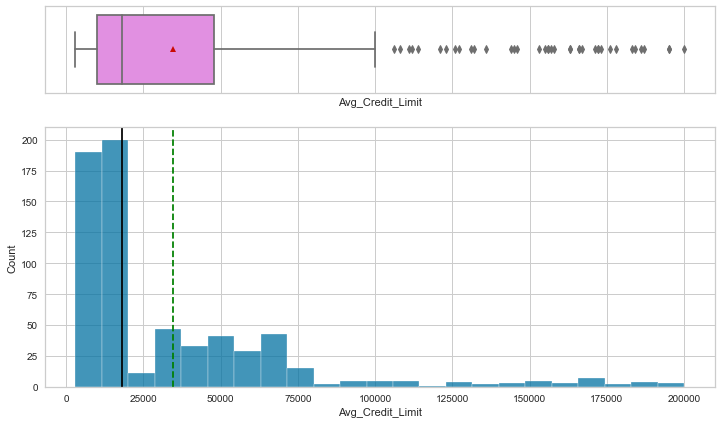

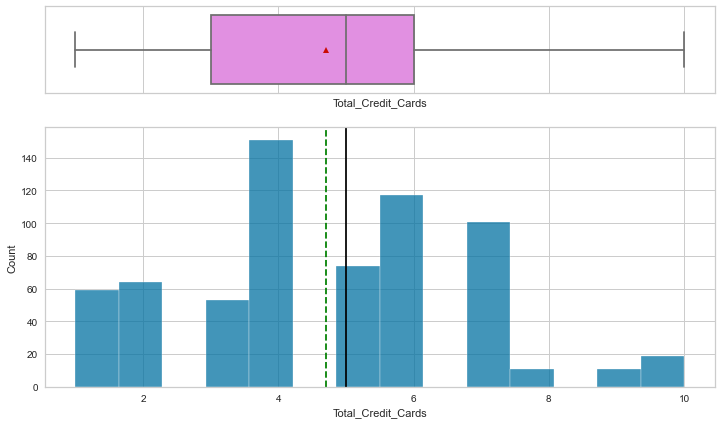

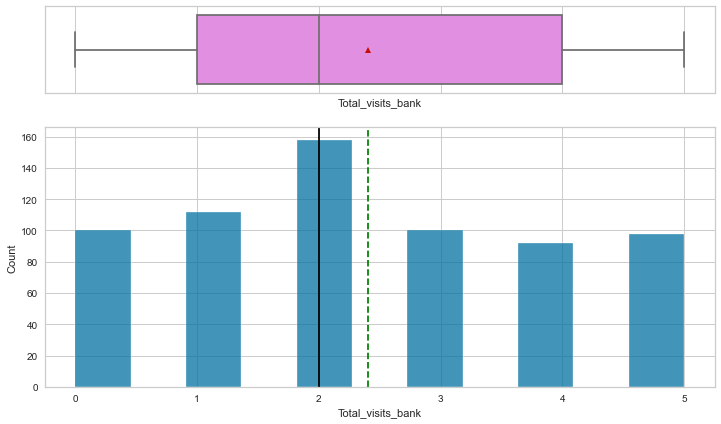

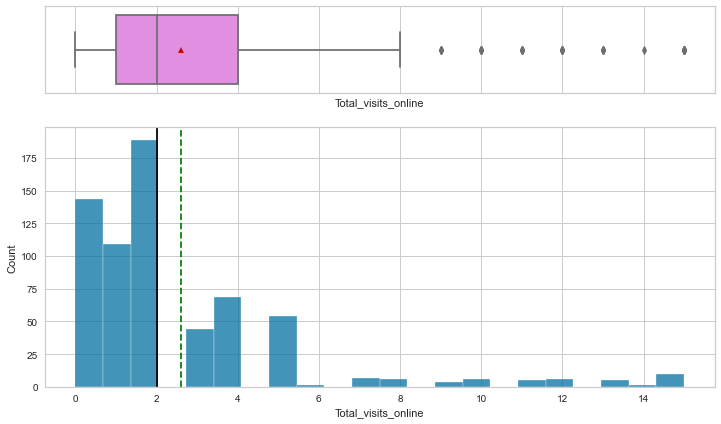

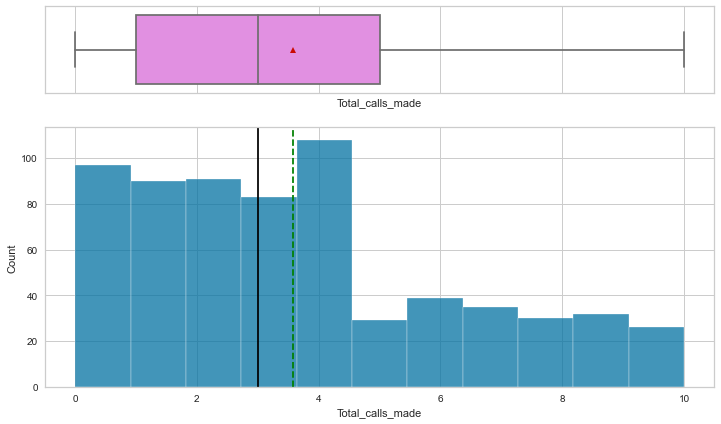

In [16]:
for col in data.columns:
    histogram_boxplot(data, col)

Observations:
* Avg_Credit_Limit is heavily right skewed, with Outliers at the right whisker
* Total_Credit_Cards is left skewed and have no outliers
* Total_visits_bank is right skewed with mean ~ 2.5
* Total_visits_online is right skewed with Outliers at the right whisker
* Total_calls_made is also right skewed and has no Outliers

In [17]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values()
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

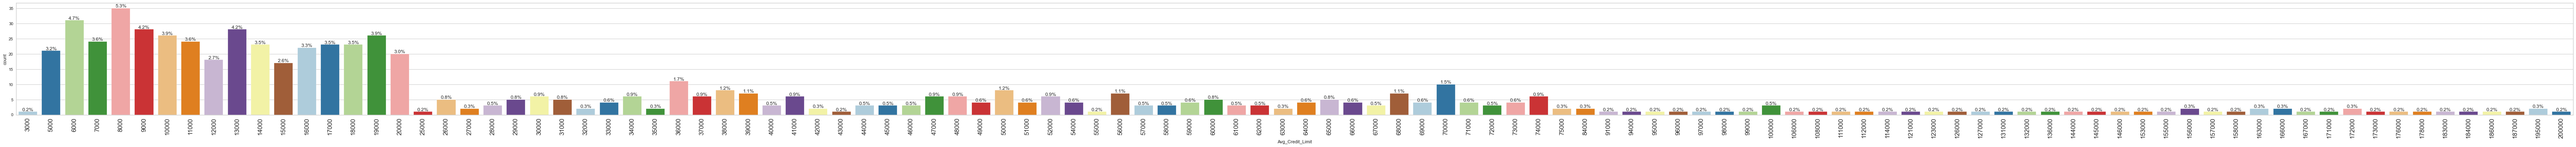

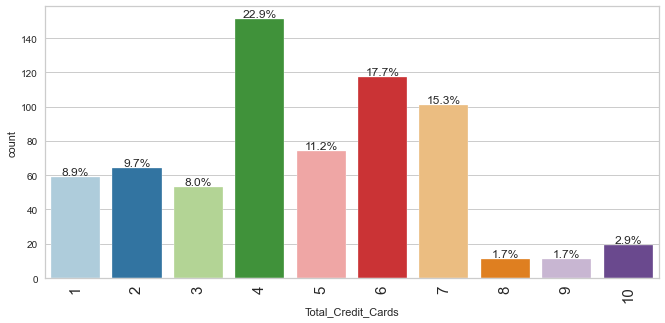

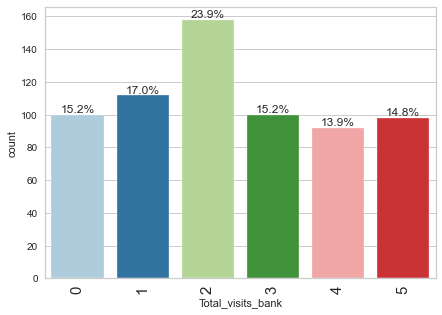

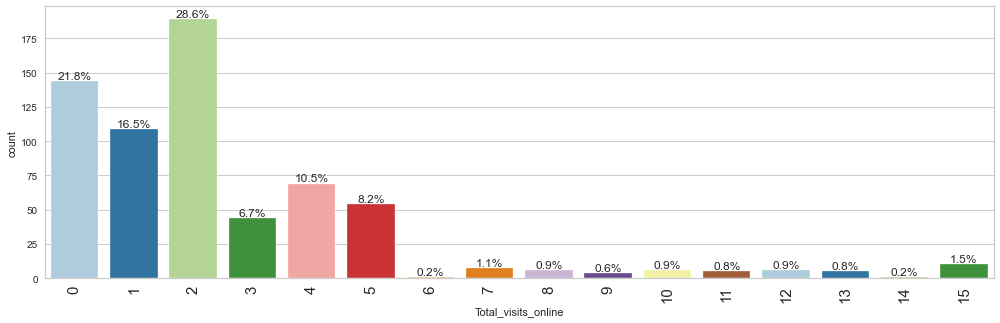

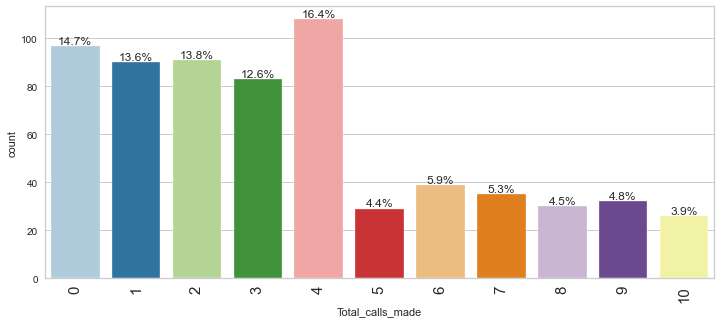

In [18]:
for col in data.columns:
    labeled_barplot(data, col, perc=True)

Observations:
* Credit Limit is spread out with the highest values below 20000
* 4 numbers of Total Credit Cards is the most, followed by 6
* Total_visits_bank is the highest at 2 visits yearly, with ~24% of attendance
* Total_visits_online is also the highest at 2 yearly visits, with 28.6% of attendance
* Total_calls_made is the highest at below 4 calls yearly

## Bivariate Analysis

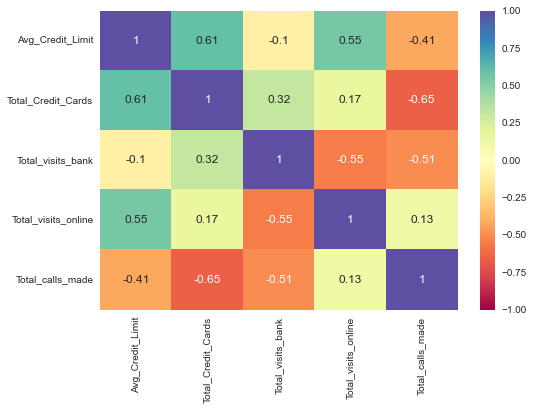

In [19]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral');
plt.show()

Observations:
* Positive:

    Avg_Credit_Limit and Total_Creait_Cards
    
    Total_visits_online and Avg_Credit_Limit
    
    Somewhat correlation between Total_visits_bank and Total_Credit_Cards
    
    
* Negative:

    Total_Credit_Cards and Total_calls_made
    
    Total_visits_bank and Total_visits_online
    
    Total_visits_bank and Total_calls_made
    
    Somewhat correlation between Avg_Credit_Limit and Total_calls_made

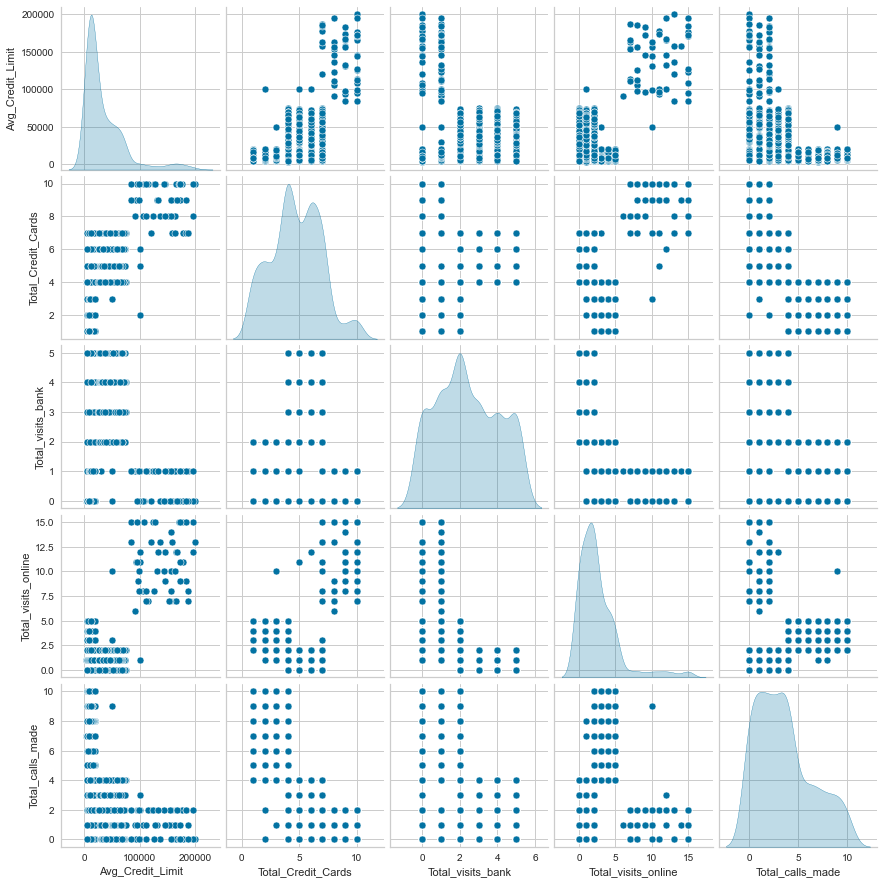

In [20]:
sns.pairplot(data, diag_kind='kde');
plt.show()

Based on above pairplot, 4 cllusters can be visualized.

There is a relationship can be visualized between Avg_Credit_Limit and Total_visits_online; Avg_Credit_Limit and Total_Credit_Cards; Total_Credit_Cards and Total_visits_online; Total_visits_online and Total_visits_bank

Also, based on above KDE plot, looks as there might be at least 3 clusters on each columns

# Data Preprocessing

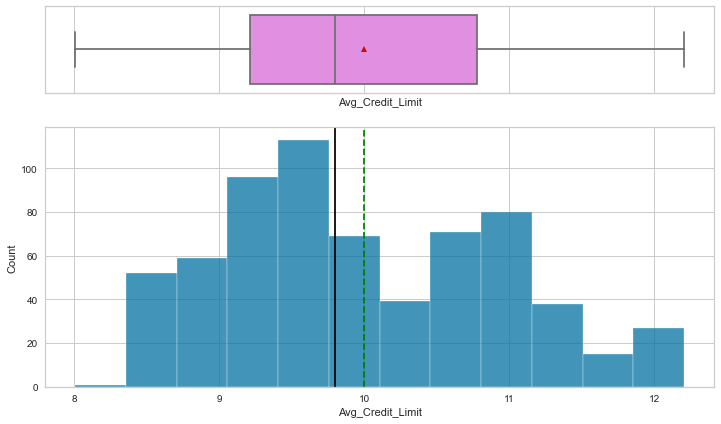

In [21]:
# Let's use log transformation to ease up on Ouliers for Avg_Credit_Limit column
data['Avg_Credit_Limit'] = np.log(data['Avg_Credit_Limit'])
histogram_boxplot(data, 'Avg_Credit_Limit')

In [22]:
# Create original datasets
data_kmeans = data.copy()
data_hierarchical = data.copy()

In [23]:
# Create an object for RobustScaler
scaler = RobustScaler()

# Let's scale up the columns
data_scaled = scaler.fit_transform(data)

In [24]:
# create a new dataframe with scaled columns
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled_df_hierarchical = pd.DataFrame(data_scaled, columns=data.columns)

In [25]:
data_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,0.126218,0.593511,-1.142255,-0.374717,0.0,0.625283,1.535077
Total_Credit_Cards,660.0,-0.097980,0.722612,-1.333333,-0.666667,0.0,0.333333,1.666667
Total_visits_bank,660.0,0.134343,0.543938,-0.666667,-0.333333,0.0,0.666667,1.000000
Total_visits_online,660.0,0.202020,0.978575,-0.666667,-0.333333,0.0,0.666667,4.333333
Total_calls_made,660.0,0.145833,0.716329,-0.750000,-0.500000,0.0,0.500000,1.750000


The columns got scaled up using StandardScaler and looks good.

# K-Means Clustering

Number of Clusters: 1 	Average Distortion: 1.4592183616097325
Number of Clusters: 2 	Average Distortion: 1.2431198444858476
Number of Clusters: 3 	Average Distortion: 0.8432182202618118
Number of Clusters: 4 	Average Distortion: 0.7703455703757605
Number of Clusters: 5 	Average Distortion: 0.7325868207631353
Number of Clusters: 6 	Average Distortion: 0.7067400835226307
Number of Clusters: 7 	Average Distortion: 0.6774989644226683
Number of Clusters: 8 	Average Distortion: 0.6559892806522735


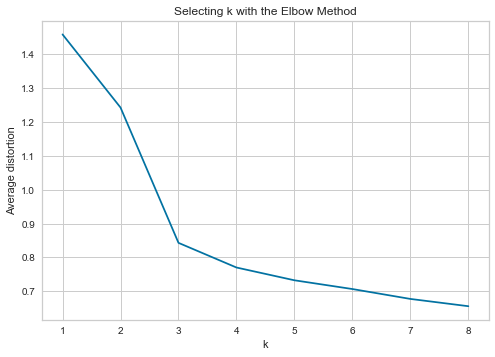

In [26]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(data_scaled_df)
    prediction = model.predict(data_scaled_df)
    distortion = (sum(np.min(cdist(data_scaled_df, model.cluster_centers_, 'euclidean'), axis=1))
                  / data_scaled_df.shape[0])
    meanDistortions.append(distortion)
    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)
    
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Based on Elbow curve graph 3 clusters looks to be a good fit. 

Let's find the silhouette score:

For n_clusters = 2, the silhouette score is 0.5707698584372072)
For n_clusters = 3, the silhouette score is 0.5060003897477424)
For n_clusters = 4, the silhouette score is 0.3583825893296035)
For n_clusters = 5, the silhouette score is 0.26943853528931905)
For n_clusters = 6, the silhouette score is 0.25716797731772556)
For n_clusters = 7, the silhouette score is 0.22736409342372566)
For n_clusters = 8, the silhouette score is 0.22258245342548752)
For n_clusters = 9, the silhouette score is 0.2175901202632138)


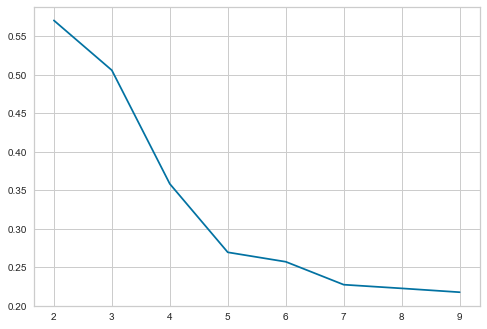

In [27]:
# Lets'c check on silhouette score
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((data_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Based on silhouette score 3 clusters show the best result: 0.51

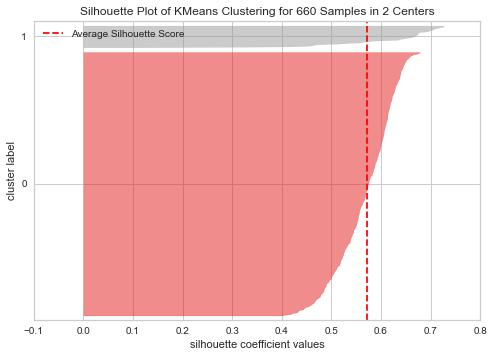

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(data_scaled_df);
visualizer.show()

2 Clusters  has different width, cross avg Silhoutte score line, have different silhouette score, however 0 cluster has too many records, while Cluster 1 has a lot less.

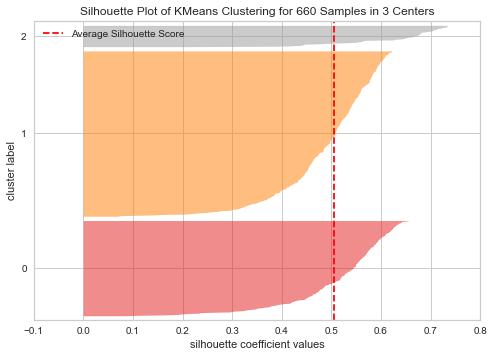

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled_df);
visualizer.show()

3 Clusters has different width, cross avg Silhoutte score line, have different silhouette scores and all values are positive. Could be a good fit

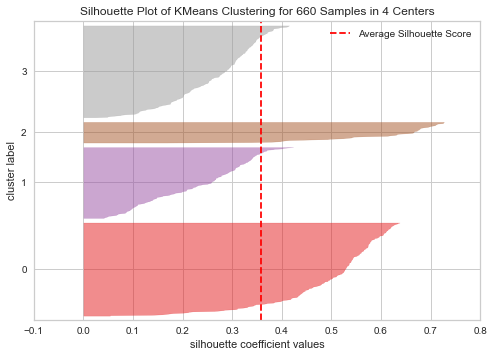

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(data_scaled_df)
visualizer.show()

4 Clusters  has different width, cross avg Silhouette score line, and all values are positive, however cluster 1 and 3 has identical Silhoutte score range. So 4 clusters is not a good candidate for K number

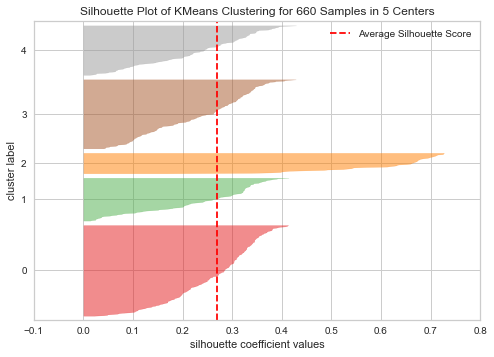

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(data_scaled_df)
visualizer.show()

5 Clusters => Cluster 3 and 4 has the same width, and cluster 3 and 1 has identical Silhouette score, so the number 5 is not a good fit.

Based on above silhouette visualization, cluster=3 shows the highest score

Number of Clusters: 1 	Average Distortion: 1.4592183616097325
Number of Clusters: 2 	Average Distortion: 1.2431198444858476
Number of Clusters: 3 	Average Distortion: 0.8432182202618118
Number of Clusters: 4 	Average Distortion: 0.7703455703757605
Number of Clusters: 5 	Average Distortion: 0.7325868207631353
Number of Clusters: 6 	Average Distortion: 0.7066820631646035
Number of Clusters: 7 	Average Distortion: 0.6773769407849067
Number of Clusters: 8 	Average Distortion: 0.6593251534129781


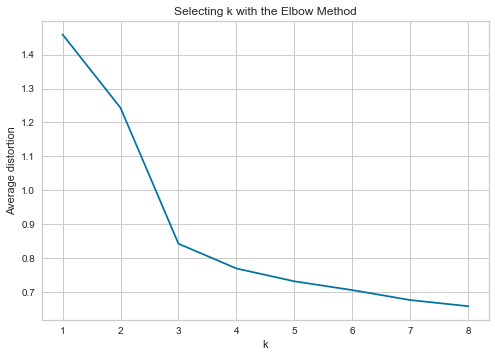

In [32]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(data_scaled_df)
    prediction = model.predict(data_scaled_df)
    distortion = (sum(np.min(cdist(data_scaled_df, model.cluster_centers_, 'euclidean'), axis=1))
                  / data_scaled_df.shape[0])
    meanDistortions.append(distortion)
    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)
    
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

In [33]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_scaled_df)

KMeans(n_clusters=3, random_state=1)

In [34]:
# adding kmeans cluster labels to the original and scaled dataframes
data_kmeans["K_means_segments"] = kmeans.labels_
data_scaled_df["K_means_segments"] = kmeans.labels_

# Cluster Profiling

In [35]:
# create profile grouping based on cluster values
cluster_profile = data_kmeans.groupby("K_means_segments").mean()

In [36]:
cluster_profile["count_in_each_segments"] = (
    data_kmeans.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [37]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,9.316815,2.408072,0.937220,3.565022,6.896861,223
1,10.151190,5.509044,3.480620,0.981912,1.997416,387
2,11.825513,8.740000,0.600000,10.900000,1.080000,50


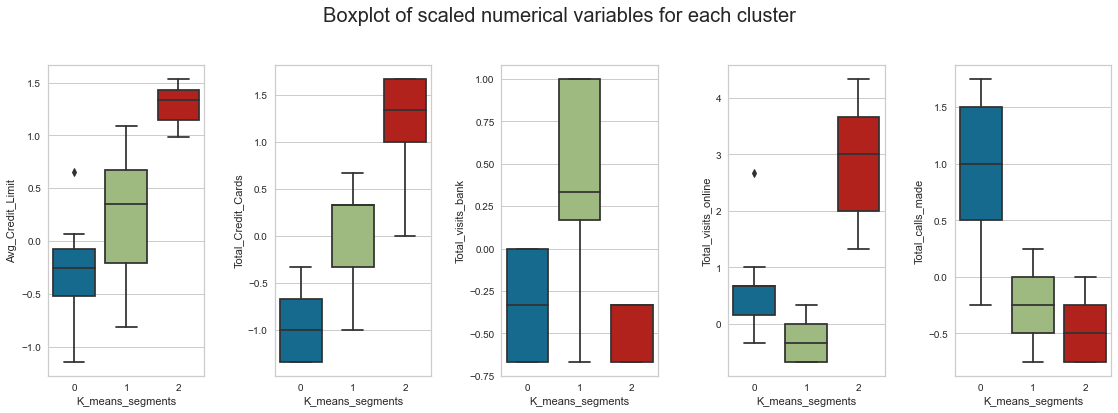

In [38]:
num_cols = data_scaled_df.columns
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=data_scaled_df[num_cols[counter]],
        x=data_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

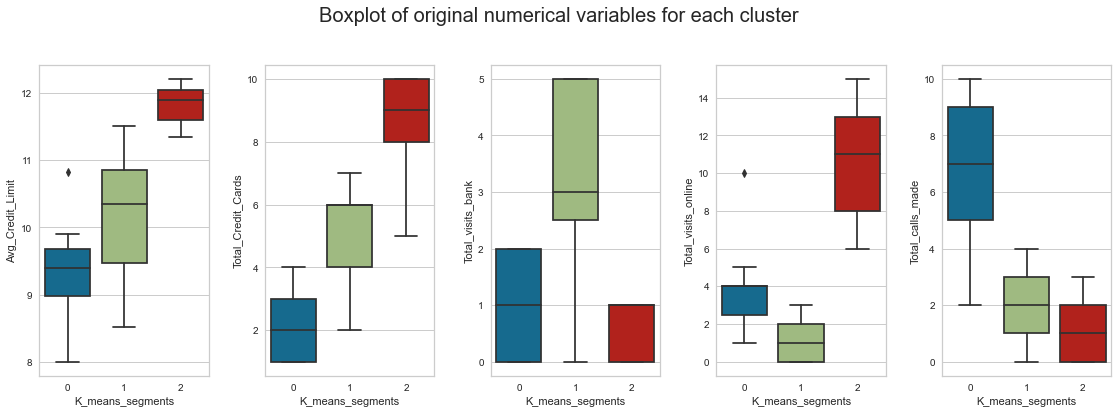

In [39]:
num_cols = data_kmeans.columns
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=data_kmeans[num_cols[counter]],
        x=data_kmeans["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

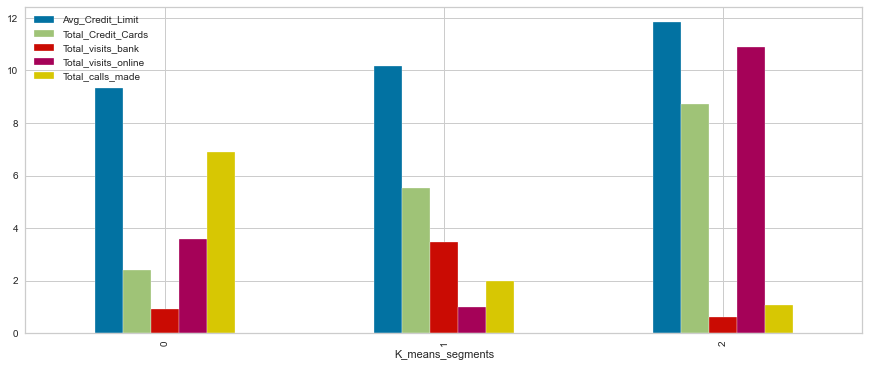

In [40]:
data_kmeans.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6));
plt.show()

Insights:

* The dataset has been segmented into 3 clusters

  Cluster 0:
    
    * Group contains the customers with the lowest Average Credit Limit
    * Customers of this group don't own more than 5 credit cards, hence explains the lowest credit limit
    * Group visits the bank less than a half of the total number, so ranging from 0 to 2
    * Online logging in happens from 2 to 4 times out of 15 total visits. Happening ~ less than 30%
    * Call center of the bank had a high volume of calls from this group with a wide range from 1 to 10
    
  Cluster 1:
    
    * Group 1 contains the customers with a wide range of credit limits ranging above Group 0 but below Group 2
    * Number of Credit cards ranges between 2 and 7, between Groups 0 and 2
    * Visits to the bank happens the most for this group, ranging from 1 to 5
    * The online visits happen the least for this group, as they prefer to visit in person
    * Calls to the center ranges from 0 to 4, in the middle between groups 0 and 2
    
  Cluster 2:
  * Contains the Customers with the highest Avg Credit Limit
  * The most number of Credit Cards are owned by the Group 
  * The Group has the lowest number of visits to the bank with a maximum of 1 visit
  * Group has the most visits online to the bank, ranging from 6 to 15
  * The least number of calls made by this group

# Hierarchical Clustering

In [41]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df_hierarchical, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled_df_hierarchical))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7949493614333882.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8495694257851759.
Cophenetic correlation for Euclidean distance and average linkage is 0.8884748812658516.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8781418220922714.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7170187922049345.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8695825906867014.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8823674343013104.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8543819040154002.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7298159647214209.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.4335857665731296.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8034981110325194.
Cophenetic co

In [42]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8884748812658516, which is obtained with Euclidean distance and average linkage.


### Let's explore different linkage methods with Euclidean distance since it gives the best results.

In [43]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(data_scaled_df_hierarchical, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(data_scaled_df_hierarchical))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7949493614333882.
Cophenetic correlation for complete linkage is 0.8495694257851759.
Cophenetic correlation for average linkage is 0.8884748812658516.
Cophenetic correlation for centroid linkage is 0.8895395685599304.
Cophenetic correlation for ward linkage is 0.7461399444796893.
Cophenetic correlation for weighted linkage is 0.8781418220922714.


In [44]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8895395685599304, which is obtained with centroid linkage.


### Let's see the dendrograms for the different linkage methods with eucledean distance

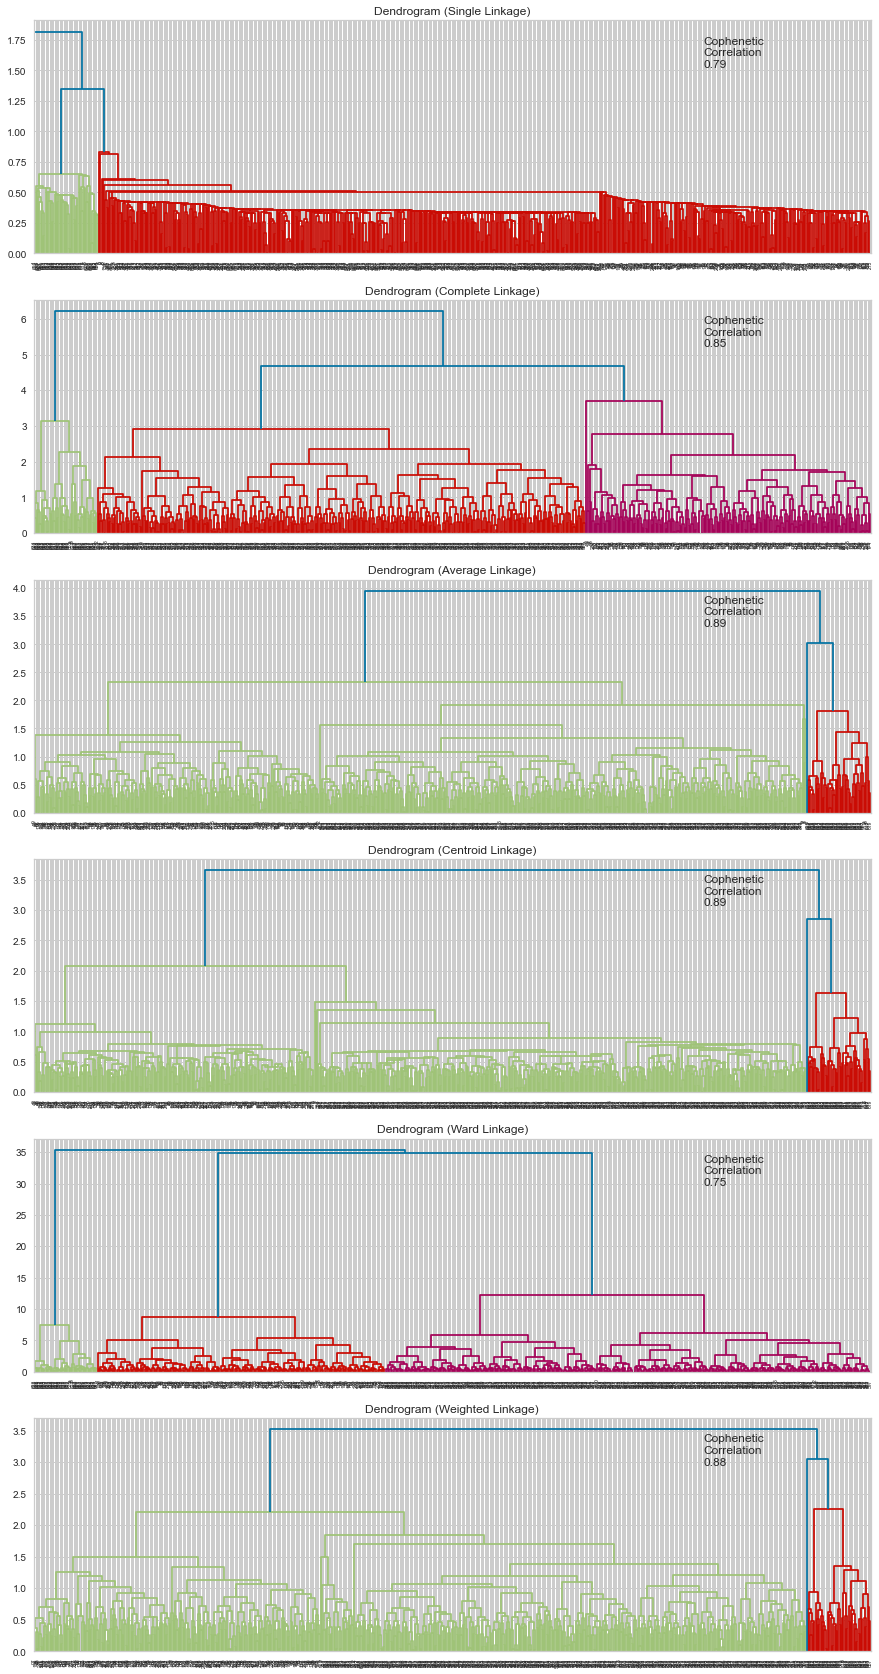

In [45]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled_df_hierarchical, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df_hierarchical))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

Cophenetic score is the highest for Average and Centroid linkages of Euclidean distance = 89%. However if we look into the well-defined clusters on the graph, I'd pick the Average Linkage with cut-off line at 2.5, hence 3 clusters.

For n_clusters = 2, the silhouette score is 0.5707698584372072)
For n_clusters = 3, the silhouette score is 0.4574229584892409)
For n_clusters = 4, the silhouette score is 0.4819999541296182)
For n_clusters = 5, the silhouette score is 0.390073396515947)
For n_clusters = 6, the silhouette score is 0.3797494555315375)
For n_clusters = 7, the silhouette score is 0.3099817375521083)


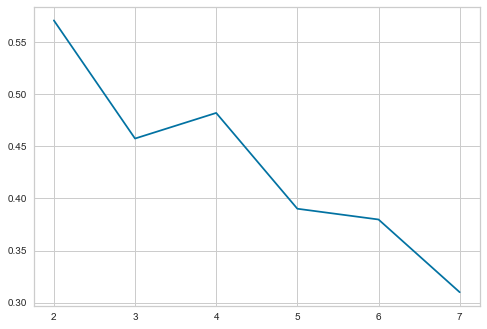

In [46]:
# Lets'c check on silhouette score on Hierarchial Clustering
sil_score = []
cluster_list = list(range(2, 8))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="average")
    preds = clusterer.fit_predict((data_scaled_df_hierarchical))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_scaled_df_hierarchical, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Clusters=4 shows better result where silhouette score is 0.48. Cluster=3 score is not far from it => 0.46. Let's try 4 clusters:

In [47]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
HCmodel.fit(data_scaled_df_hierarchical)

# adding hierarchical cluster labels to the original and scaled dataframes

data_scaled_df_hierarchical ["HC_Clusters"] = HCmodel.labels_
data_hierarchical["HC_Clusters"] = HCmodel.labels_

cluster_profile_hierarchical = data_hierarchical.groupby("HC_Clusters").mean()
cluster_profile_hierarchical["count_in_each_segments"] = (
    data_hierarchical.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)
# let's display cluster profiles
cluster_profile_hierarchical.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,10.159328,5.507812,3.479167,0.973958,1.979167,384
1,11.825513,8.740000,0.600000,10.900000,1.080000,50
2,10.819778,3.000000,0.000000,10.000000,9.000000,1
3,9.307372,2.448889,0.977778,3.515556,6.853333,225


From the above results with Cluster=4, we can notice there are 4 groups, where Group2 contains only 1 customer, with the no visits to the bank, and with the highest number of calls_made. We shouldn't be clustering a single record into the group. So let's try cluster=3

In [48]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(data_scaled_df_hierarchical)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [49]:
# adding hierarchical cluster labels to the original and scaled dataframes

data_scaled_df_hierarchical ["HC_Clusters"] = HCmodel.labels_
data_hierarchical["HC_Clusters"] = HCmodel.labels_

# Cluster Profiling

In [50]:
cluster_profile_hierarchical = data_hierarchical.groupby("HC_Clusters").mean()

In [51]:
cluster_profile_hierarchical["count_in_each_segments"] = (
    data_hierarchical.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

In [52]:
# let's display cluster profiles
cluster_profile_hierarchical.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,9.314064,2.451327,0.973451,3.544248,6.862832,226
1,11.825513,8.740000,0.600000,10.900000,1.080000,50
2,10.159328,5.507812,3.479167,0.973958,1.979167,384


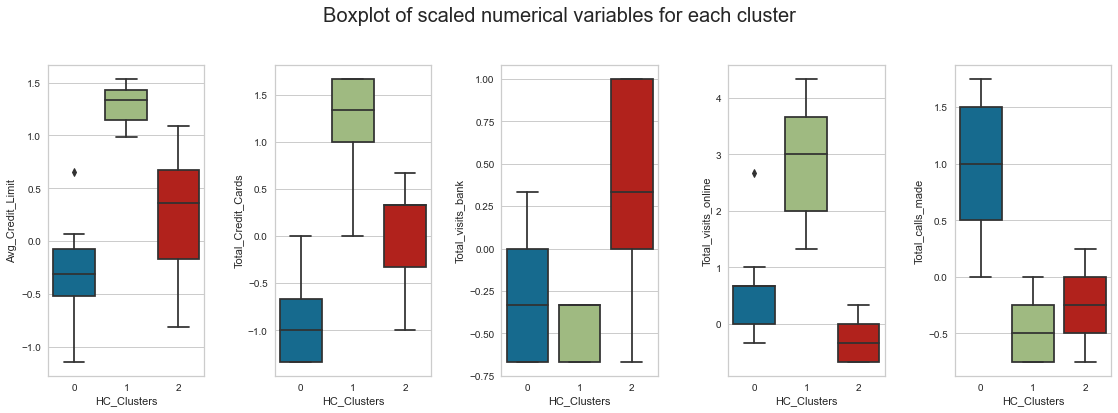

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=data_scaled_df_hierarchical[num_cols[counter]],
        x=data_scaled_df_hierarchical["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

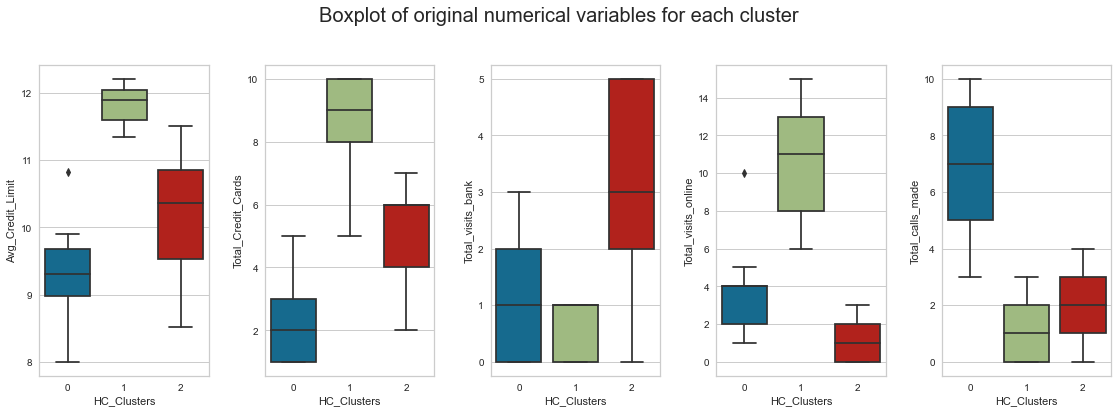

In [54]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=data_hierarchical[num_cols[counter]],
        x=data_hierarchical["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

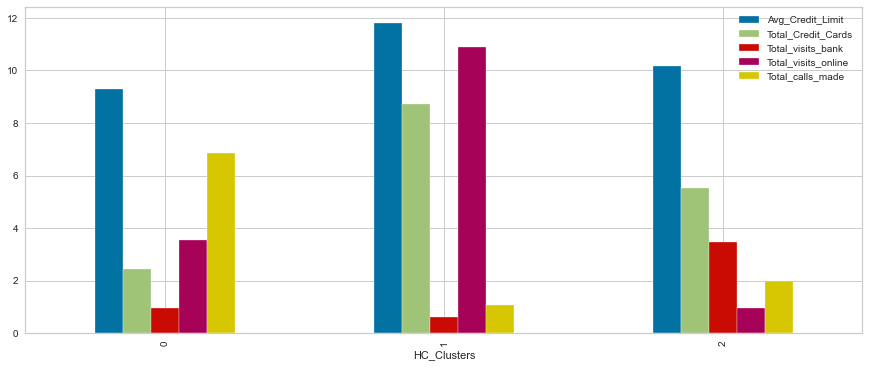

In [55]:
data_hierarchical.groupby("HC_Clusters").mean().plot.bar(figsize=(15, 6));
plt.show()

Now the Clusters makes more sense. We concluded to segment customers into 3 groups.
    
  Cluster 0:
        
    * Group contains the customers with the lowest Average Credit Limit
    * Customers of this group don't own more than 5 credit cards, hence explains the lowest credit limit
    * Group visits the bank less than a half of the total number, so ranging from 0 to 2
    * Online logging in happens from 2 to 4 times out of 15 total visits. Happening ~ less than 30%
    * Call center of the bank had a high volume of calls from this group with a wide range from 1 to 10
    
  Cluster 1:
    
      * Contains the Customers with the highest Avg Credit Limit
      * The most number of Credit Cards are owned by the Group 
      * The Group has the lowest number of visits to the bank with a maximum of 1 visit
      * Group has the most visits online to the bank, ranging from 6 to 15
      * The least number of calls made by this group   
    
  Cluster 2:
    
    * Group 2 contains the customers with a wide range of credit limits ranging above Group 0 but below Group 1
    * Number of Credit cards ranges between 2 and 7, between Groups 0 and 1
    * Visits to the bank happens the most for this group, ranging from 0 to 5
    * The online visits happen the least for this group, as they prefer to visit in person
    * Calls to the center ranges from 0 to 4, in the middle between groups 0 and 1

# K-Means vs Hierarchical

In [56]:
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,9.316815,2.408072,0.93722,3.565022,6.896861,223
1,10.151190,5.509044,3.48062,0.981912,1.997416,387
2,11.825513,8.740000,0.60000,10.900000,1.080000,50


In [57]:
cluster_profile_hierarchical

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,9.314064,2.451327,0.973451,3.544248,6.862832,226
1,11.825513,8.740000,0.600000,10.900000,1.080000,50
2,10.159328,5.507812,3.479167,0.973958,1.979167,384


Observations:
* Both Profiles has segmented the customers into 3 groups based on provided bank information.
* Silhouette score for K_Means = 0.51, while for HC = 0.62
* The profiles are pretty similarly distributed, based on a count of each segment, with a very slight difference.
* Hierarchical profile's Group 1 is defined on K_Means_Profile as the Group 2, as they show exact identical values for each column. So group order is swapped.
* Group 0 on HC_Profile has 3 records more than on K_Means_Profile, however Group on both Profiles represent the customers with the lowest Credit 
* Group 1 on K_means and Group 2 on HC represent the customers who are the most attended group of people, they have the highest number of visits to the bank, and with a wide range of credit_Limit and Credit_Cards.
* Group 2 on K_Means and Group 1 on HC represent the customers with the highest credit_Limit and credit_Cards. They are Bank's favorites as they prefer to sign-on to Online banking. Both Profiles has detected this group of customer very easily and well defined, as cluster on both profiles has the exact match on values and number of customers.


Overall, it can be said, that both profiles did a good job on segmenting the dataset into the clusters. They reflect and carry the same meaningful information. Yes, there are slight differences on number of customers between the groups, and the order of clusters is different. However, both models can be used in research and building the Unsupervised Models. 

### Insights & Recommendations:

    * Customers from Cluster=0, has the least credit limit and credit cards. The group could be offered to apply for a special deal like BRONZE Credit Cards with a higher APR (since bank is concerned to get a dividend out of these offers). This way customers could have a potential grow in credit score. Also this group prefers Call Centers, so it would be beneficial to have 24 hours of customer support on a call to keep customers satisfied.
    * Customers from Cluster=1, prefers to attend the bank in person. So this group can be handled properly by the bank representatives.
    * Customers from Cluster=2, are the clients with the highest credit limits and many cards. This group requires online support essentially, since they use it heavily. So keep upgrading and adding new features to the online banking would be a good practice to keep this group satisfied.
    
    From the above descriptions, we can conclude that either existing or new customers can be groupped based on Credit limit and number of credit cards, and preferences of contact with the bank. The clustering can define the customer type and his preferences so the bank can apply the best service and solutions for them.